
#### The Data

<br>
<br>
The dataset contains an additional ~10,000 consumers. Note these consumer may not have been randomly selected. On January 1 2022, these consumers were incentivized with an offer to earn \$5 cash back if they dined at least once that month. Each row represents a single incentivized consumer. Columns:

    - consumer_id: Unique identifier for each consumer
    - gender: encoding of consumer gender as 0 or 1 (labels not important)
    - partner: encoding of the partner (e.g. United Airlines vs Hilton Hotels) to which the consumer belongs (0 to 10, labels not important).
    - join_dt: the date the consumer joined the company
    - churn_dt: if a consumer formally deletes their account, this is the effective date of that deletion. (We stop tracking their dines after this date, and they recieve no bonuses after this date). Null indicates the consumer is still a member of the program as of Jan 01, 2022
<br>
The dataset file contains 8 years of hypothetical daily dining events from the incentivized consumers. This includes both befor, during, and after the incentivized time-frame:

    - consumer_id: Unique identifier for each consumer
    - dine_dt: The date on which the consumer made a purchase at any restaurant on our platform

#### PROBLEM: Evaluate the performance of the Incentive
 
 Assume the following cost/benefit break down:
 
    - Every dine generates $10 in revenue for the company
    
    - Every offer redemption (i.e. they consumer recieved the offer and dined in the month of January 2022) cost us $5 in incentives.
<br>  
  
  
Please assess the success of this incentive.
In your work below, be sure to demonstrate:

- How you construct a baseline/control metric to compare the incentivized consumers against.
- How you calculate incremental lift in value generated by the incentives.
- How you calculate ROI (return on investment)
- What confounds are you weary of?
- If we wanted to re-run this incentive is there a specific cohort of consumers that you would recommend incentivizing? Is there a cohort of consumers that we should omit from the incentive?




In [34]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt 
from scipy.stats import levene, ttest_ind, mannwhitneyu, jarque_bera
import numpy as np

control_consumers = pd.read_csv('datasets/challenge1__consumers.csv.gz')
control_consumers['received_incentive'] = False
treatment_consumers = pd.read_csv('datasets/challenge2__withheld_consumers.csv.gz')
treatment_consumers['received_incentive'] = True

consumers = pd.concat([control_consumers, treatment_consumers]).sort_values('consumer_id').reset_index(drop=True)

del control_consumers, treatment_consumers

consumer_dines = pd.concat([pd.read_csv('datasets/challenge1__dines.csv.gz'), pd.read_csv('datasets/challenge2__withheld_dines.csv.gz')]).sort_values(['dine_dt', 'consumer_id']).reset_index(drop=True)

- step 1: formulate the hypothesis -> H_0 -> the incentive doesn't affect clients dining count via out the year
- step 2: formulate the hypothesis -> H_1 -> the incentive affects clients dining count via out the year
- step 3: during vs after on received_incentive or not
- step 4: independent-t test -> p value and t statisic on 
- step 5: internpret results 

## Step 1 and 2
### H_0 -> the incentive doesn't affect clients dining count via out the year
### H_1 -> the incentive affects clients dining count via out the year

- I created three new features: before_total_cnt, during_total_cnt, after_total_cnt to evalute the incentive event:
- before_total_cnt: the total dining count of each consumer from 2021-02 to 2021-12
- during_total_cnt: the total dining count of each consumer from 2022-01
- after_total_cnt:  the total dining count of each consumer from 2022-02 to 2022-12

## Step 3
- to evalute the effectiness of the incentive, we dont want to include the inactive consumers.
    - To define whether a consumer is active or not, a time window will be set so that duing that timeframe, if the consumers have 0 count on the dining, they will be ruled out.

since we want to assume the efftectiveness of the incentives, I naively set the time window = 11 months so that the timeframe is roughly a year:
-  2021-02 <---------- 2022-01 ----------> 2022-12

In [35]:
consumer_dines['dine_dt'] = pd.to_datetime(consumer_dines['dine_dt'])
consumer_dines['dine_dt'] = consumer_dines['dine_dt'].dt.strftime('%Y-%m')
INCENTIVE_YEAR_MONTH = pd.to_datetime('2022-01').strftime('%Y-%m')
SIGNIFICANCE_LEVEL = 0.05

In [36]:
def collect_data_within_time_window(time_window: int, 
                                    consumer_dines: pd.DataFrame, 
                                    consumers: pd.DataFrame
                                    ) -> pd.DataFrame:
        max_time_window = round((pd.to_datetime(max(consumer_dines['dine_dt'])) - pd.to_datetime(INCENTIVE_YEAR_MONTH)).days/30)
        
        if time_window > max_time_window or time_window < 1:
                time_window = max_time_window

        observation_window_start = (pd.to_datetime(INCENTIVE_YEAR_MONTH) + relativedelta(months=-time_window)).strftime('%Y-%m')
        observation_window_end = (pd.to_datetime(INCENTIVE_YEAR_MONTH) + relativedelta(months=time_window)).strftime('%Y-%m')

        print(f'{observation_window_start} <---------- {INCENTIVE_YEAR_MONTH} ----------> {observation_window_end}')
        print(f'{len(observation_window_start)*' '}  {time_window} month(s)  {len(INCENTIVE_YEAR_MONTH)* ' '} {time_window} month(s)')

        before = pd.DataFrame(consumer_dines[(observation_window_start <= consumer_dines['dine_dt']) & (consumer_dines['dine_dt'] < INCENTIVE_YEAR_MONTH)].groupby('consumer_id')['dine_dt'].count()).rename(columns={'dine_dt': 'before_total_cnt'})
        during = pd.DataFrame(consumer_dines[consumer_dines['dine_dt'] == INCENTIVE_YEAR_MONTH].groupby('consumer_id')['dine_dt'].count()).rename(columns={'dine_dt': 'during_total_cnt'})
        after  = pd.DataFrame(consumer_dines[(consumer_dines['dine_dt'] > INCENTIVE_YEAR_MONTH) & (consumer_dines['dine_dt'] <= observation_window_end)].groupby('consumer_id')['dine_dt'].count()).rename(columns={'dine_dt': 'after_total_cnt'})

        before_during_after = before.merge(during, how='outer', on='consumer_id').merge(after, how='outer', on='consumer_id').fillna(0)
        final = before_during_after.merge(consumers.set_index('consumer_id'), how='left', on='consumer_id')
        print(f'''
                before: {observation_window_start} - {(pd.to_datetime(INCENTIVE_YEAR_MONTH) + relativedelta(months=-1)).strftime('%Y-%m')}
                during: {INCENTIVE_YEAR_MONTH}
                after : {(pd.to_datetime(INCENTIVE_YEAR_MONTH) + relativedelta(months=+1)).strftime('%Y-%m')} - {observation_window_end}
        ''')



        return final

final = collect_data_within_time_window(11, consumer_dines, consumers)

omitted_incentived_consumer = consumers[consumers['received_incentive']==True].merge(final[final['received_incentive'] == True].reset_index()[['consumer_id']], on='consumer_id', how='left',  indicator=True)
omitted_incentived_consumer = omitted_incentived_consumer[omitted_incentived_consumer['_merge']=='left_only'].drop(columns=['_merge'])

# confirm that during those incentived consumers, the latest dine date happens before '2021-02'
assert max(consumer_dines.merge(omitted_incentived_consumer[['consumer_id']], how='inner', on='consumer_id')['dine_dt']) < '2021-02'

final

2021-02 <---------- 2022-01 ----------> 2022-12
         11 month(s)          11 month(s)

                before: 2021-02 - 2021-12
                during: 2022-01
                after : 2022-02 - 2022-12
        


,before_total_cnt,during_total_cnt,after_total_cnt,gender,partner,market,join_dt,churn_dt,received_incentive
consumer_id,,,,,,,,,
1,0.0,0.0,2.0,0,1,1,2021-10-22,NaN,False
6,3.0,1.0,6.0,1,1,1,2017-03-29,NaN,False
8,0.0,0.0,4.0,0,6,1,2022-06-08,NaN,False
9,1.0,0.0,0.0,0,9,5,2016-01-26,NaN,False
10,1.0,0.0,0.0,0,5,2,2017-10-26,NaN,False
...,...,...,...,...,...,...,...,...,...
299989,12.0,0.0,0.0,0,3,3,2019-11-14,NaN,False
299990,9.0,2.0,24.0,1,6,5,2021-01-07,NaN,False
299991,1.0,0.0,5.0,0,4,2,2021-08-02,NaN,False


## Step 4

Text(30.519367283950622, 0.5, 'after_total_cnt')

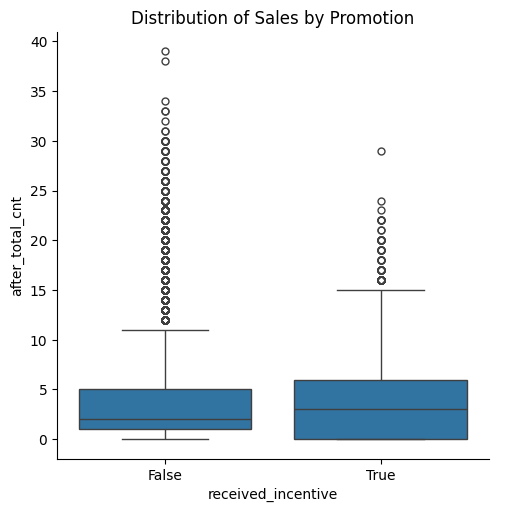

In [37]:
# We can see some outliers
import seaborn as sns
sns.catplot(data=final, x='received_incentive', y='after_total_cnt', kind='box')

plt.title('Distribution of Sales by Promotion')
plt.xlabel('received_incentive')
plt.ylabel('after_total_cnt')

- null hypothesis        -> the mean of total_count in both groups are the same
- alternative hypothesis -> the mean of total_count in both groups are not the same
- significance level is set to 5% 0.05
- The dataframe containing the "received_incentive == True" is the baseline group
- The dataframe containing the "received_incentive == False" is the test group. 
- A/B testing has been going on for n month before and after the incentive month

In [38]:
def remove_outliers(df):
    while True:
        shape_before = df.shape
        numeric_columns = ['before_total_cnt', 'during_total_cnt', 'after_total_cnt']
        df_clean = df.copy()  
        for column in numeric_columns:
            Q1 = df_clean[column].quantile(0.25)
            Q3 = df_clean[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
            
            shape_after = df_clean.shape

        if shape_before == shape_after:
            break
        df = df_clean
    return df_clean

control = final[final['received_incentive'] == False]
treatment  = final[final['received_incentive'] == True]
control = remove_outliers(control)
treatment = remove_outliers(treatment)

pd.concat([control, treatment]).received_incentive.value_counts()

received_incentive
False    75101
True      3799
Name: count, dtype: int64

In [39]:
final = pd.concat([control.sample(len(treatment)), treatment])
final.groupby("received_incentive").agg({"after_total_cnt": ["mean", "median", "count", "sum"]}).astype(int).style.background_gradient(cmap='viridis', axis=0, subset=('after_total_cnt')).format("{:.2f}")

In [40]:
final.groupby(["received_incentive",'gender']).agg({"after_total_cnt": ["mean", "median", "count", "sum"]}).astype(int).style.background_gradient(cmap='viridis', axis=0, subset=('after_total_cnt')).format("{:.2f}")

In [41]:
final.groupby(["received_incentive",'partner']).agg({"after_total_cnt": ["mean", "median", "count", "sum"]}).astype(int).style.background_gradient(cmap='viridis', axis=0, subset=('after_total_cnt')).format("{:.2f}")

In [42]:
final.groupby(["received_incentive",'market']).agg({"after_total_cnt": ["mean", "median", "count", "sum"]}).astype(int).style.background_gradient(cmap='viridis', axis=0, subset=('after_total_cnt')).format("{:.2f}")

Text(30.519367283950622, 0.5, 'after_total_cnt')

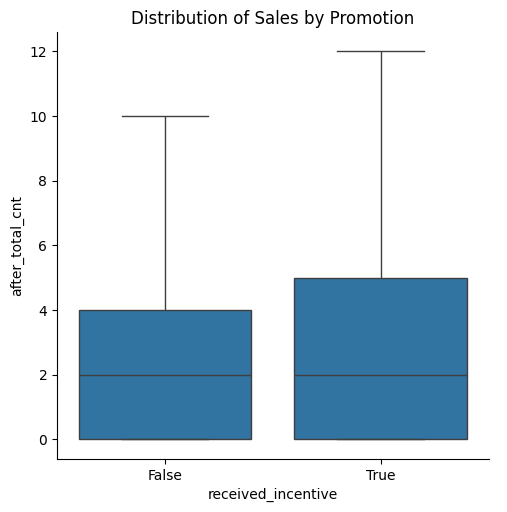

In [43]:
sns.catplot(data=final, x='received_incentive', y='after_total_cnt', kind='box')

plt.title('Distribution of Sales by Promotion')
plt.xlabel('received_incentive')
plt.ylabel('after_total_cnt')

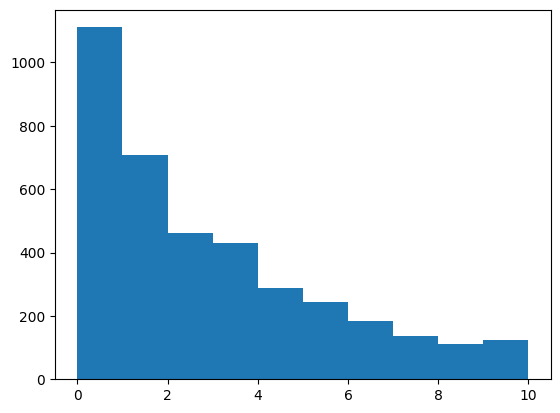

In [44]:
from matplotlib import pyplot
pyplot.hist(final[final['received_incentive']==False]['after_total_cnt'])
pyplot.show()

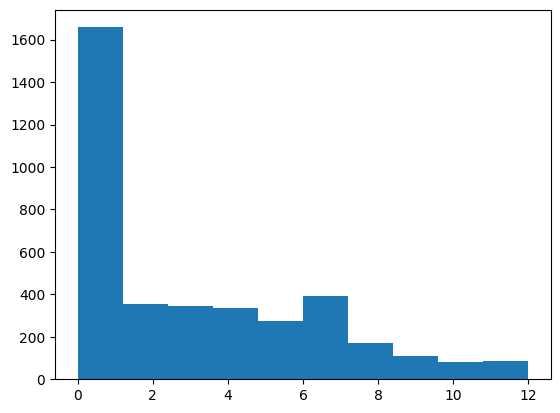

In [45]:
pyplot.hist(final[final['received_incentive']==True]['after_total_cnt'])
pyplot.show()

In [46]:
group_data = []
for grp in final['received_incentive'].unique():
    grp_data = final[final['received_incentive'] == grp]['after_total_cnt']
    group_data.append(grp_data)

In [47]:
jarque_bera(group_data[1])[1] < SIGNIFICANCE_LEVEL

True

In [48]:
from typing import Dict, Any
def check_normality_and_equal_variance_and_get_ttest_p(df: pd.DataFrame) -> Dict[str, Any]:
    group_data = []
    normality_tests = []

    for grp in df['received_incentive'].unique():
        grp_data = df[df['received_incentive'] == grp]['after_total_cnt']
        group_data.append(grp_data)
        normality_tests.append(jarque_bera(grp_data)[1] < SIGNIFICANCE_LEVEL) # both baseline and test have more than 2000 rows -> jarque_bera

    # Check if all groups follow normal distribution
    normality_check = all(normality_tests)

    if normality_check: # "H0: Normal Distribution"
        # Parametric Test (normally distributed)
        # Assumption: equal variances?
        _, levene_p = levene(*group_data)
        leveneTest = levene_p < SIGNIFICANCE_LEVEL

        if leveneTest:
            equal_var = False
        else:
            equal_var = True
        _, p = ttest_ind(*group_data, equal_var=equal_var) 
    else:
        _, p = mannwhitneyu(*group_data, alternative='two-sided')
    return {'p':p, 'normality_check':normality_check, 'leveneTest':leveneTest}

In [49]:
print(f'''
    A/B Testing Hypothesis on wether recieved_incentive will affect the after_total_cnt
    H0: {', '.join(['no_incentive','yes_incentive'])} are the same
    H1: {', '.join(['no_incentive','yes_incentive'])} are not the same
''')

res = check_normality_and_equal_variance_and_get_ttest_p(final)
p, normality_check, leveneTest = res['p'], res['normality_check'], res['leveneTest']

ab_test = pd.DataFrame({"received_incentive_difference_hypothesis":[p < SIGNIFICANCE_LEVEL], "p-value":[p]})
ab_test["Test Type"] = ['Parametric' if normality_check else 'Non-Parametric']
ab_test['received_incentive_difference_hypothesis'] = np.where(ab_test[f"received_incentive_difference_hypothesis"] == False, "Fail to Reject H0", "Reject H0")
ab_test["Comment"] = np.where(ab_test[f"received_incentive_difference_hypothesis"] == "Fail to Reject H0", f"no_incentive & yes_incentive => similar!", f"no_incentive & yes_incentive => not similar!")
if normality_check:
    ab_test["equal_variance"] = np.where(leveneTest == False, "Yes", "No")
    ab_test = ab_test[["Test Type", "equal_variance", f"received_incentive_difference_hypothesis", "p-value", "Comment"]]
else:
    ab_test = ab_test[["Test Type", f"received_incentive_difference_hypothesis", "p-value", "Comment"]]
ab_test    



    A/B Testing Hypothesis on wether recieved_incentive will affect the after_total_cnt
    H0: no_incentive, yes_incentive are the same
    H1: no_incentive, yes_incentive are not the same



,Test Type,equal_variance,received_incentive_difference_hypothesis,p-value,Comment
0,Parametric,No,Reject H0,7.961636e-17,no_incentive & yes_incentive => not similar!


## Step 5
According to the AB test, since the p-value from t-test is smaller than the 0.05, we have enough evidence to reject H0 hypothesis => which means the effectiveness of the incentive has make enough differences to cause the treatment group having different dining count distribution than the control group.

The main confounds I am weary of is that treatment group have selection bias, causing the lift and ROI overstated.

In [ ]:
t = final[final['received_incentive'] == True]['after_total_cnt'].sum()
c = final[final['received_incentive'] == False]['after_total_cnt'].sum() 

incremental_lift = (t-c)/c
print(f'incremental lift: {round(incremental_lift*100, 2)}%.')
    
# Every dine generates $10 in revenue for the company
revenue = 10*t
# Every offer redemption (i.e. they consumer recieved the offer and dined in the month of January 2022) cost us $5 in incentives.
cost = 5 * len(final[(final['received_incentive'] == True) & (final['during_total_cnt'] > 0)])

roi = ((revenue*incremental_lift/11 - cost)/cost) * 100
print(f'roi: {round(roi, 2)}%')

incremental lift: 22.23%.
roi: -59.02%


Based on the sampled df statistic analysis, the graphs show that some of groups in the (incentive treatment) have higher mean of after_dining_count than  in the control group
- in terms of the mean(after_dining_count)
    - gender 0 in treatment > gender 0 in control
    - partner 3, 6, 7 in treatment > partner 3, 6, 7 in control
    - market 2,5,6 in treatment > market 2, 5, 6 in control
- these groups can be further tested for incentivizing



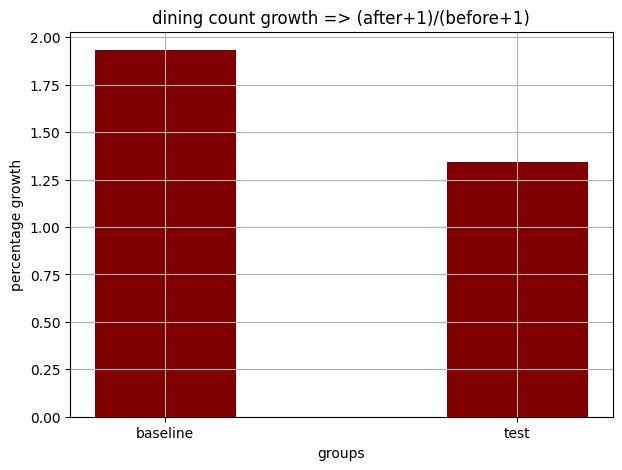

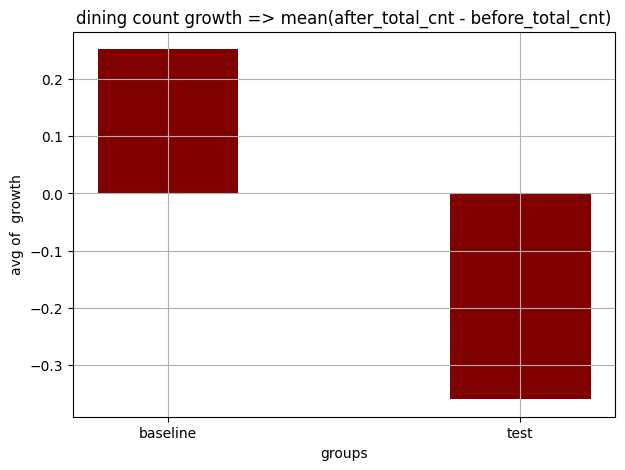

In [58]:
# from typing import Callable, Dict

# def get_adjusted_avg_percentage_growth(df: pd.DataFrame) -> float:
#         # mean( (after_total_cnt + 1)/(before_total_cnt+1) )
#         return ((df['after_total_cnt']+1)/(df['before_total_cnt']+1)).mean()

# def get_avg_dine_count(df: pd.DataFrame) -> float:
#     # mean( during_total_cnt - before_total_cnt)
#     return (df['after_total_cnt'] - df['before_total_cnt']).mean()

# def barplot(func: Callable, data: Dict[str, pd.DataFrame], kargs):
#     plt.figure(figsize = (7, 5))
#     plt.bar(data.keys(), 
#             list(map(func, data.values())), 
#             color ='maroon', 
#             width = 0.4)
    
#     plt.xlabel(kargs.get('xlabel'))
#     plt.ylabel(kargs.get('ylabel'))
#     plt.title(kargs.get('title'))
#     plt.grid(True)
#     plt.show()



# data: Dict[str, pd.DataFrame] = {
#     'baseline': control,
#     'test': treatment,
#     # 'test_during_yes': adjusted_test_during_yes,
#     # 'test_during_no': adjusted_test_during_no
# }
# kargs = {'xlabel': 'groups',
#          'ylabel': 'percentage growth',
#          'title' : 'dining count growth => (after+1)/(before+1)'
# }
# barplot(get_adjusted_avg_percentage_growth, data, kargs)

# kargs = {'xlabel': 'groups',
#          'ylabel': 'avg of  growth',
#          'title' : 'dining count growth => mean(after_total_cnt - before_total_cnt)'
#     }
# barplot(get_avg_dine_count, data, kargs)
